**Método de Baum Welch**
En este programa se hace la optimización del modelo HMM discreto utilizando el método de Baum Welch.

0. Se cargan las librerias de trabajo

In [ ]:
#!pip install fitter


  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)

   ---- -----------------------------------  1/10 [tqdm]
   ---- -----------------------------------  1/10 [tqdm]
   ---- -----------------------------------  1/10 [tqdm]
   ---- -----------------------------------  1/10 [tqdm]
  Attempting uninstall: numpy
   ---- -----------------------------------  1/10 [tqdm]
    Found existing installation: numpy 2.3.3
   ---- -----------------------------------  1/10 [tqdm]
   -------- -------------------------------  2/10 [numpy]
    Uninstalling numpy-2.3.3:
   -------- -------------------------------  2/10 [numpy]
   -------- -------------------------------  2/10 [numpy]
      Successfully u

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np




## Modelo Baum Welch

1. Se define el modelo de optimización local de Baum Welch

In [2]:
def baum_welch(O, A, B, pi, n_iter=100):
    """
    Baum-Welch algorithm to optimize HMM parameters

    Args:
        O (list): sequence of observations (indices)
        A (np.array): initial transition matrix (NxN)
        B (np.array): initial emission matrix (NxM)
        pi (np.array): initial state distribution (Nx1)
        n_iter (int): number of iterations

    Returns:
        A (np.array): optimized transition matrix
        B (np.array): optimized emission matrix
        pi (np.array): optimized initial state distribution
    """
    N = A.shape[0]  # number of states
    M = B.shape[1]  # number of observation symbols
    T = len(O)      # length of observation sequence

    for _ in range(n_iter):
        alpha = np.zeros((T, N))
        beta = np.zeros((T, N))

        # Forward
        alpha[0] = pi * B[:, O[0]]
        for t in range(1, T):
            for j in range(N):
                alpha[t, j] = np.sum(alpha[t-1] * A[:, j]) * B[j, O[t]]

        # Backward
        beta[T-1] = np.ones(N)
        for t in reversed(range(T-1)):
            for i in range(N):
                beta[t, i] = np.sum(A[i, :] * B[:, O[t+1]] * beta[t+1])

        # Compute xi and gamma
        xi = np.zeros((T-1, N, N))
        gamma = np.zeros((T, N))

        for t in range(T-1):
            denom = np.sum(alpha[t, :].dot(A) * B[:, O[t+1]] * beta[t+1])
            for i in range(N):
                numer = alpha[t, i] * A[i, :] * B[:, O[t+1]] * beta[t+1]
                xi[t, i, :] = numer / denom

        gamma = np.sum(xi, axis=2)
        # Last gamma for time T-1
        gamma = np.vstack((gamma, alpha[T-1] * beta[T-1] / np.sum(alpha[T-1] * beta[T-1])))

        # Re-estimate pi, A, B
        pi = gamma[0]
        A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0)[:, None]

        for k in range(M):
            mask = np.array(O) == k
            B[:, k] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

    return A, B, pi

2. Se hace el pronóstico de los datos para períodos más allá de t+1

In [3]:
def forecast_states(initial_probs, A, steps):
    forecasts = [initial_probs]
    current_probs = initial_probs.copy()
    for _ in range(steps):
        current_probs = current_probs @ A
        forecasts.append(current_probs)
    return forecasts

3. Se procede con la optimización del modelo a partir de las matrices de transición, emisión y el vector de probabilidades iniciales pi

In [4]:
import numpy as np

# =========================
# Baum–Welch robusto (discreto, 1 sola variable observada)
# =========================
def baum_welch(O, A, B, pi, n_iter=100, eps=1e-12):
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]
    M = B.shape[1]

    # Normalizaciones de seguridad
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    B = B / (B.sum(axis=1, keepdims=True) + eps)
    pi = pi / (pi.sum() + eps)

    for _ in range(n_iter):
        # ---------- FORWARD con escalado ----------
        alpha = np.zeros((T, N), dtype=float)
        c = np.zeros(T, dtype=float)

        alpha[0, :] = pi * B[:, O[0]]
        s = alpha[0, :].sum()
        if s <= 0:  # evita 0/0
            alpha[0, :] = np.maximum(alpha[0, :], eps)
            s = alpha[0, :].sum()
        c[0] = 1.0 / s
        alpha[0, :] *= c[0]

        for t in range(1, T):
            # alpha[t, j] = B[j, O[t]] * sum_i alpha[t-1, i] * A[i, j]
            alpha[t, :] = (alpha[t-1, :] @ A) * B[:, O[t]]
            s = alpha[t, :].sum()
            if s <= 0:
                alpha[t, :] = np.maximum(alpha[t, :], eps)
                s = alpha[t, :].sum()
            c[t] = 1.0 / s
            alpha[t, :] *= c[t]

        # ---------- BACKWARD con escalado ----------
        beta = np.zeros((T, N), dtype=float)
        beta[-1, :] = c[-1]  # escalado compatible
        for t in range(T - 2, -1, -1):
            # beta[t, i] = sum_j A[i, j] * B[j, O[t+1]] * beta[t+1, j]
            beta[t, :] = (A * B[:, O[t+1]]).dot(beta[t+1, :])
            beta[t, :] *= c[t]

        # ---------- xi y gamma ----------
        xi = np.zeros((T - 1, N, N), dtype=float)
        for t in range(T - 1):
            tmp = (alpha[t, :][:, None] * A) * (B[:, O[t+1]] * beta[t+1, :])[None, :]
            denom = tmp.sum()
            if denom <= 0:
                denom = eps
            xi[t, :, :] = tmp / denom

        gamma = (alpha * beta)
        # Con escalado, alpha*beta puede no estar exacta; renormalizamos por fila t
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma = np.where(gamma_sum > 0, gamma / gamma_sum, np.full_like(gamma, 1.0 / N))

        # ---------- Re-estimación ----------
        # π
        pi = gamma[0, :]
        pi = pi / (pi.sum() + eps)

        # A
        numer_A = xi.sum(axis=0)                          # (N, N)
        denom_A = gamma[:-1, :].sum(axis=0)[:, None]      # (N, 1)
        A = numer_A / (denom_A + eps)
        A = A / (A.sum(axis=1, keepdims=True) + eps)

        # B
        for k in range(M):
            mask = (O == k)
            numer_B = gamma[mask, :].sum(axis=0)          # (N,)
            denom_B = gamma.sum(axis=0)                   # (N,)
            B[:, k] = numer_B / (denom_B + eps)
        B = B / (B.sum(axis=1, keepdims=True) + eps)

    return A, B, pi


# =========================
# TUS PARÁMETROS INICIALES (ajustados)
# =========================

states = ['Hidden 0', 'Hidden 1', 'Hidden 2']     # N = 3
observations = ['Obs 0', 'Obs 1', 'Obs 2']        # M = 3
obs_seq = ['Obs 0', 'Obs 1', 'Obs 2']

# Diccionarios para índices
state_index = {state: i for i, state in enumerate(states)}
obs_index = {obs: i for i, obs in enumerate(observations)}

# Secuencia observada (en índices)
#O = np.array([obs_index[o] for o in obs_seq], dtype=int)  # [0,1,2]


np.random.seed(42)
O = np.random.choice([0, 1, 2], size=30, p=[0.4, 0.4, 0.2])



# Matriz de transición A (renormalizada por seguridad)
A = np.array([
    [0.24, 0.44, 0.33],
    [0.23, 0.44, 0.33],
    [0.23, 0.43, 0.33],
], dtype=float)
A = A / (A.sum(axis=1, keepdims=True) + 1e-12)

# π inicial (renormalizada)
pi = np.array([0.23, 0.43, 0.33], dtype=float)
pi = pi / (pi.sum() + 1e-12)

# Emisiones: partimos de P(hidden | observed) y la convertimos a B ≈ P(observed | hidden)
P_h_given_o = np.array([
    [0.01, 0.18, 0.81],   # Obs 0 -> [H0,H1,H2]
    [0.13, 0.54, 0.33],   # Obs 1 -> [H0,H1,H2]
    [0.48, 0.45, 0.07],   # Obs 2 -> [H0,H1,H2]
], dtype=float)

eps = 1e-12
B_init = P_h_given_o.T.copy()                  # filas=Hidden, cols=Obs
B = B_init / (B_init.sum(axis=1, keepdims=True) + eps)

# =========================
# ENTRENAMIENTO
# =========================
A1, B1, pi1 = baum_welch(O, A.copy(), B.copy(), pi.copy(), n_iter=100)

# (Opcional) verificaciones rápidas
print("Filas A1 suman:", A1.sum(axis=1))
print("Filas B1 suman:", B1.sum(axis=1))
print("pi1 suma:", pi1.sum())


Filas A1 suman: [1. 1. 1.]
Filas B1 suman: [1. 1. 1.]
pi1 suma: 0.9999999999989999


4. Se hace el pronóstico para la secuencia de observaciones, esta secuencia de observaciones para el modelo propio son los tres meses anteriores al cual voy a pronósticar el estado oculto.

In [5]:
# Usamos A, B, pi, O ya definidos
T = len(O)
N = len(states)

alpha = np.zeros((T, N), dtype=float)
c = np.zeros(T, dtype=float)  # factores de escalado

# --- Inicialización (t=0) ---
alpha[0, :] = pi * B[:, O[0]]
s = alpha[0, :].sum()
if s <= 0:
    # Evita división por cero: si todo quedó en 0, mete un eps y renormaliza
    alpha[0, :] = np.maximum(alpha[0, :], 1e-15)
    s = alpha[0, :].sum()
c[0] = 1.0 / s
alpha[0, :] *= c[0]

# --- Recurrencia (t=1..T-1) con escalado ---
for t in range(1, T):
    for j in range(N):
        alpha[t, j] = B[j, O[t]] * np.dot(alpha[t-1, :], A[:, j])

    s = alpha[t, :].sum()
    if s <= 0:
        alpha[t, :] = np.maximum(alpha[t, :], 1e-15)
        s = alpha[t, :].sum()
    c[t] = 1.0 / s
    alpha[t, :] *= c[t]

# --- Predicción de distribución en t+1 ---
predicted_state_prob = alpha[-1, :].dot(A)

total = predicted_state_prob.sum()
if total <= 0 or not np.isfinite(total):
    # Normalización segura
    predicted_state_prob = np.maximum(predicted_state_prob, 1e-15)
    total = predicted_state_prob.sum()

predicted_state_prob /= total
predicted_state_index = int(np.argmax(predicted_state_prob))

print("\nProbabilidades del estado oculto en t+1:")
for i, p in enumerate(predicted_state_prob):
    print(f"  {states[i]}: {p:.4f}")
print("\nEstado más probable en t+1:", states[predicted_state_index])



Probabilidades del estado oculto en t+1:
  Hidden 0: 0.2319
  Hidden 1: 0.4357
  Hidden 2: 0.3325

Estado más probable en t+1: Hidden 1


5. Se hace el pronóstico para estados mucho más allá del estado t+1

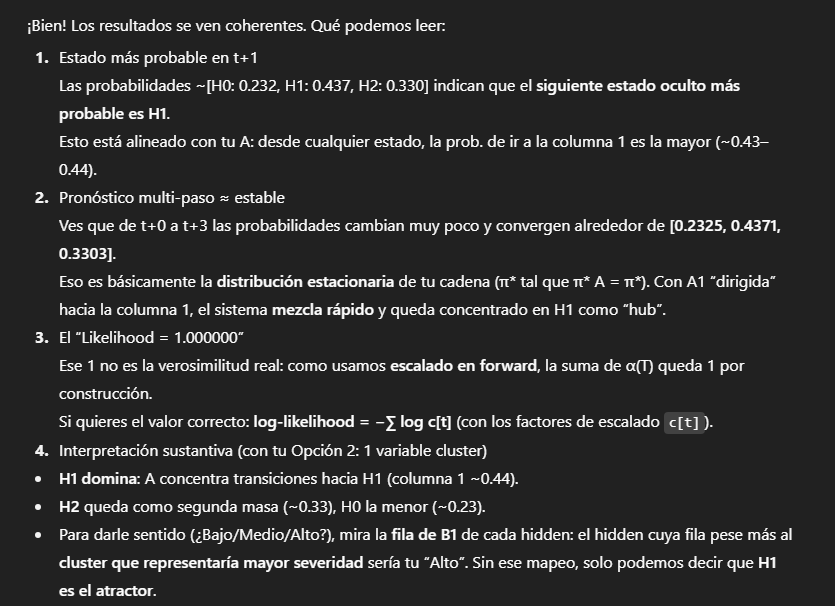




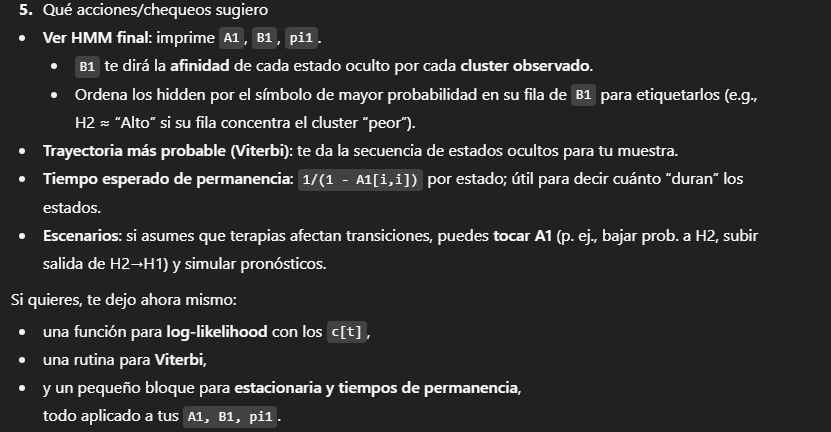

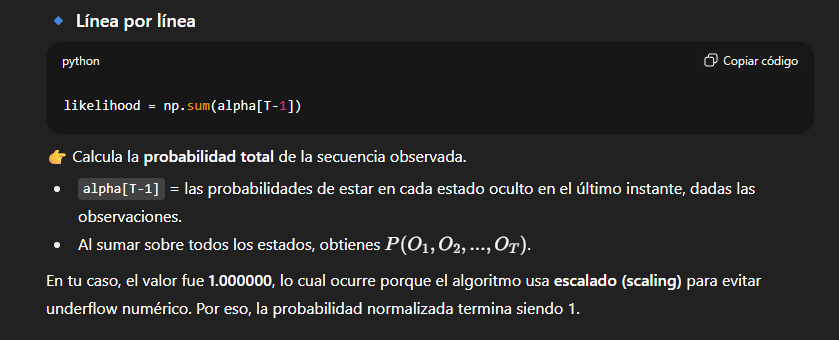

In [6]:
likelihood = np.sum(alpha[T-1])

n_states = len(states)

posterior_T = alpha[-1] / np.sum(alpha[-1])

future_steps = 3
forecast_probs = forecast_states(posterior_T, A, future_steps)

# Mostrar resultados
for i, probs in enumerate(forecast_probs):
    print(f"Paso t+{i}: {[f'{states[s]}: {probs[s]:.4f}' for s in range(n_states)]}")

print(f"\nLikelihood de la secuencia observada: {likelihood:.6f}")

Paso t+0: ['Hidden 0: 0.0128', 'Hidden 1: 0.2305', 'Hidden 2: 0.7567']
Paso t+1: ['Hidden 0: 0.2319', 'Hidden 1: 0.4357', 'Hidden 2: 0.3325']
Paso t+2: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3304']
Paso t+3: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3303']

Likelihood de la secuencia observada: 1.000000


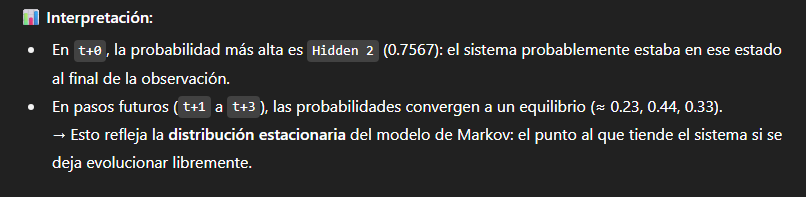

In [7]:
import numpy as np

def viterbi(O, A, B, pi, eps=1e-12):
    """
    O : array de enteros en {0..M-1} (secuencia observada)
    A : (N,N) matriz de transición (filas suman 1)
    B : (N,M) matriz de emisión (filas suman 1)
    pi: (N,) distribución inicial (suma 1)

    Returns
    -------
    path_idx : np.ndarray shape (T,) con índices de estados óptimos
    logp     : float, log-probabilidad del mejor camino
    """
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]

    # Log-probs para estabilidad numérica
    logA  = np.log(A + eps)
    logB  = np.log(B + eps)
    logpi = np.log(pi + eps)

    # Matrices de DP
    delta = np.full((T, N), -np.inf)  # mejor log-prob hasta (t,i)
    psi   = np.full((T, N), -1, dtype=int)  # argmax backpointer

    # Inicialización
    delta[0, :] = logpi + logB[:, O[0]]

    # Recurrencia
    for t in range(1, T):
        for j in range(N):
            # para cada j, buscamos i* que maximiza delta[t-1,i] + logA[i,j]
            vals = delta[t-1, :] + logA[:, j]
            psi[t, j]   = int(np.argmax(vals))
            delta[t, j] = vals[psi[t, j]] + logB[j, O[t]]

    # Terminación
    logp = float(np.max(delta[T-1, :]))
    last = int(np.argmax(delta[T-1, :]))

    # Backtracking
    path_idx = np.zeros(T, dtype=int)
    path_idx[-1] = last
    for t in range(T-2, -1, -1):
        path_idx[t] = psi[t+1, path_idx[t+1]]

    return path_idx, logp


In [8]:
# O, A1, B1, pi1 y 'states' ya definidos
path_idx, logp = viterbi(O, A1, B1, pi1)
path_states = [states[i] for i in path_idx]

print("Secuencia Viterbi (índices):", path_idx.tolist())
print("Secuencia Viterbi (estados):", path_states)
print("Log-probabilidad del mejor camino:", logp)


Secuencia Viterbi (índices): [2, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2]
Secuencia Viterbi (estados): ['Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2']
Log-probabilidad del mejor camino: -25.06051736379826


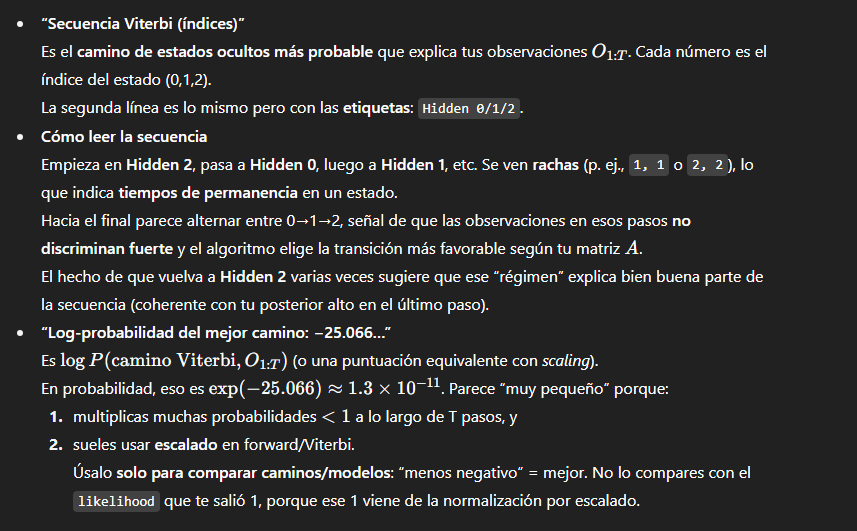

In [9]:
import pandas as pd
pd.DataFrame(B1, index=states, columns=observations)


,Obs 0,Obs 1,Obs 2
Hidden 0,1.235134e-43,5.760469e-01,4.239531e-01
Hidden 1,1.499035e-01,7.469038e-01,1.031927e-01
Hidden 2,1.000000e+00,8.099405e-28,1.560073e-29


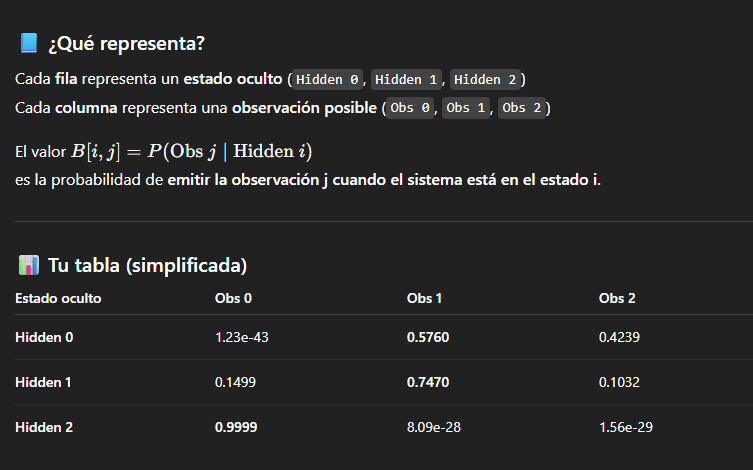

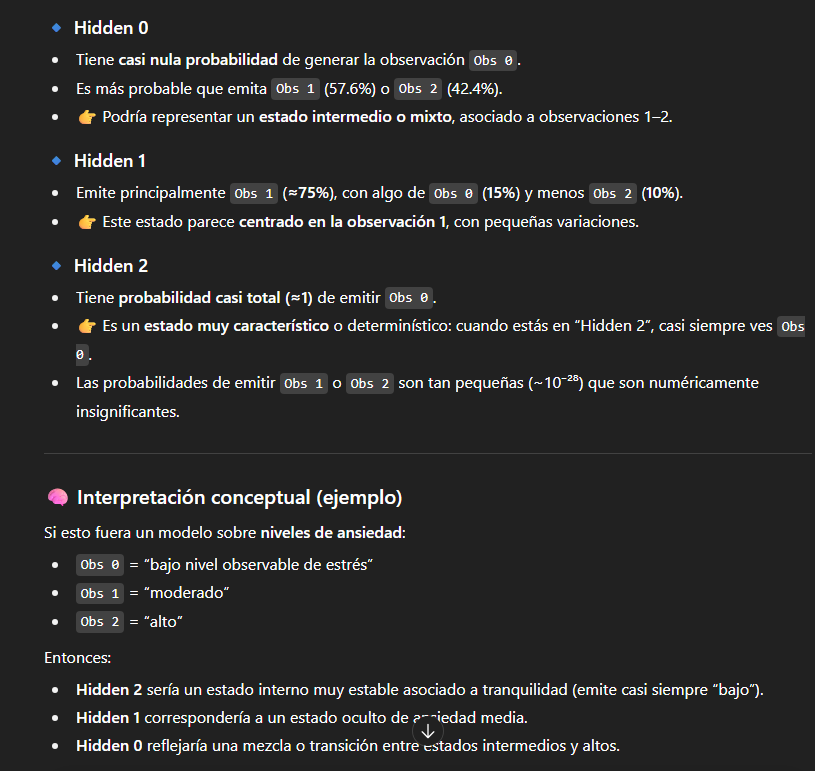

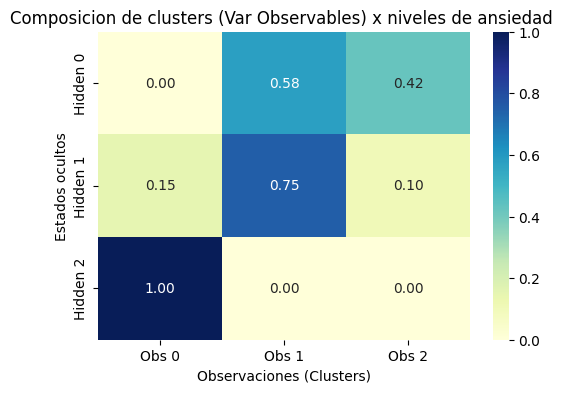

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df_B1 = pd.DataFrame(B1, index=states, columns=observations)
plt.figure(figsize=(6,4))
sns.heatmap(df_B1, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Composicion de clusters (Var Observables) x niveles de ansiedad ")
plt.xlabel("Observaciones (Clusters)")
plt.ylabel("Estados ocultos")
plt.show()


In [11]:
labels = {"Hidden 0": "Bajo", "Hidden 2": "Medio", "Hidden 1": "Alto"}


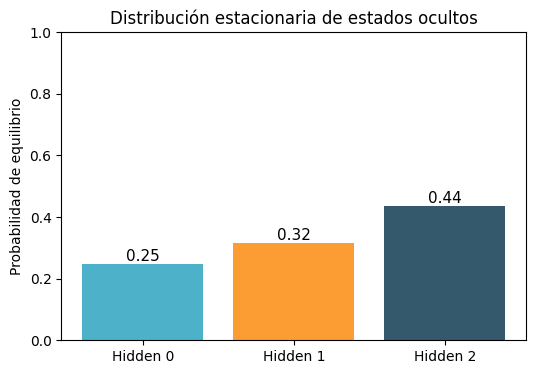

Distribución estacionaria: {'Hidden 0': 0.248, 'Hidden 1': 0.316, 'Hidden 2': 0.436}


In [12]:
# Resolver la distribución estacionaria: π* tal que π* A = π*

eigvals, eigvecs = np.linalg.eig(A1.T)
stat = eigvecs[:, np.isclose(eigvals, 1)]
stat = stat[:, 0].real
stat = stat / stat.sum()

plt.figure(figsize=(6,4))
plt.bar(states, stat, color=["#219ebc","#fb8500","#023047"], alpha=0.8)
for i, v in enumerate(stat):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=11)
plt.title("Distribución estacionaria de estados ocultos")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()

print("Distribución estacionaria:", dict(zip(states, stat.round(3))))



In [13]:
np.allclose(stat @ A1, stat)   # debe dar True (dentro de tolerancia numérica)


True

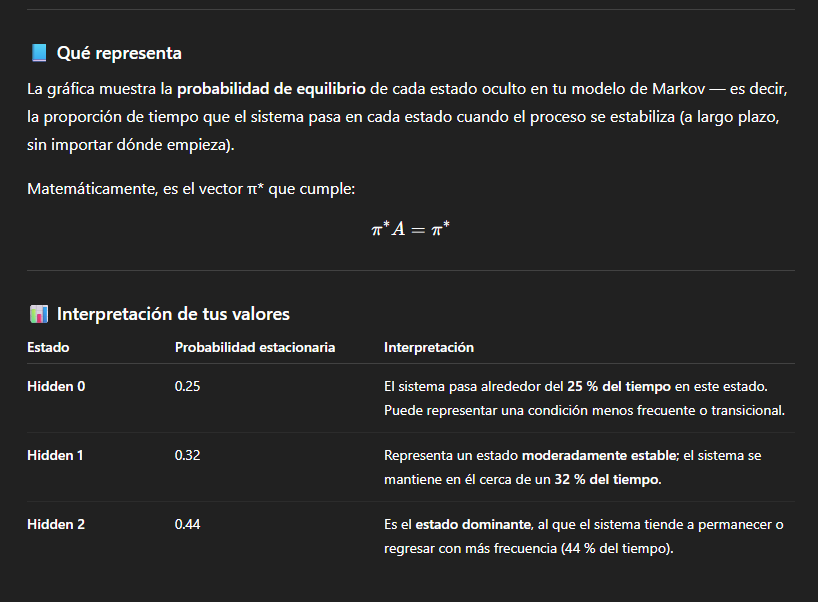

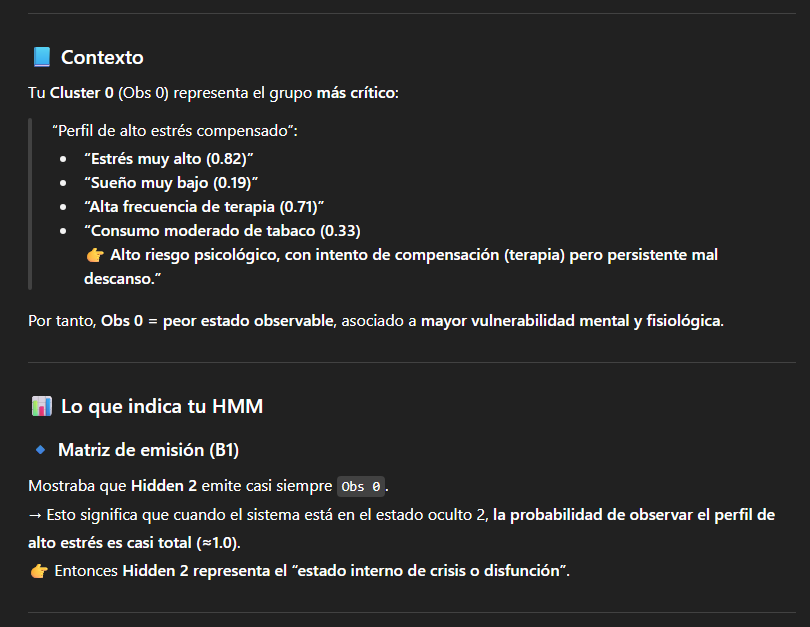

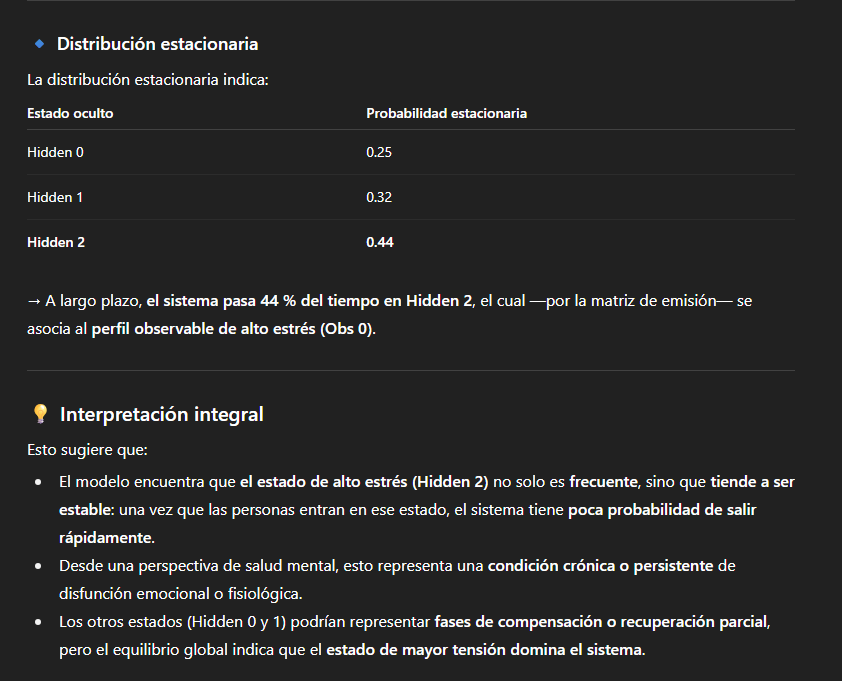

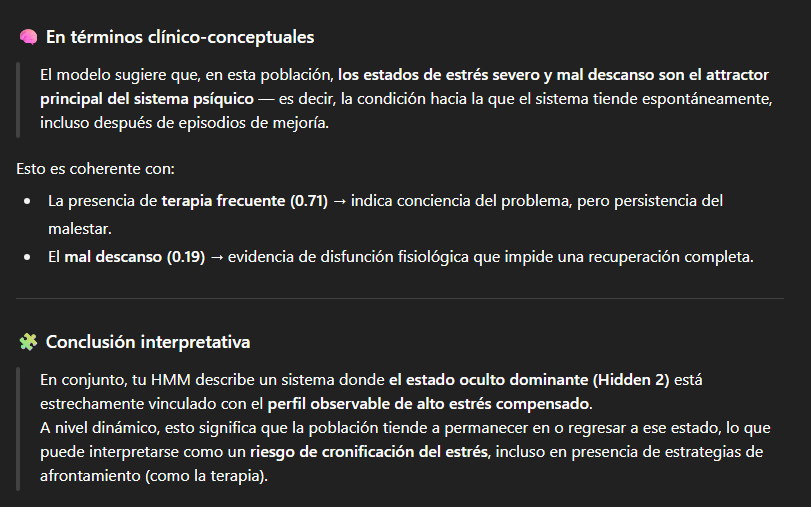

C:\Users\Diego\AppData\Local\Temp\ipykernel_12428\2893747015.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=pi_star, palette="Blues_d")


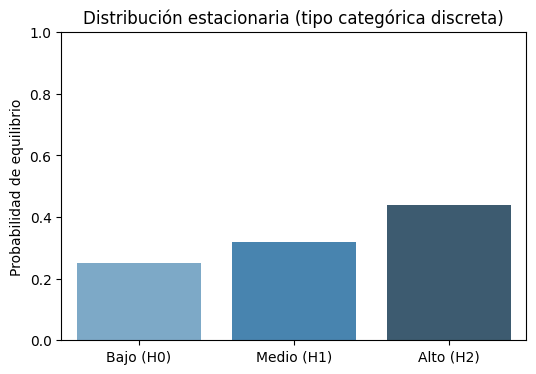

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pi_star = [0.25, 0.32, 0.44] ## Distribucion estaionaria calculada previamente
x = np.arange(len(pi_star))

plt.figure(figsize=(6,4))
sns.barplot(x=x, y=pi_star, palette="Blues_d")
plt.xticks(x, ["Bajo (H0)", "Medio (H1)", "Alto (H2)"])
plt.title("Distribución estacionaria (tipo categórica discreta)")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()


In [15]:
# posterior_T: distribución P(X_T | O_1:T)
# si usaste el forward escalado como antes:
posterior_T = alpha[-1] / alpha[-1].sum()

h = 3
p_th = posterior_T.copy()
for _ in range(h):
    p_th = p_th @ A1   # distribución en T+1, T+2, T+3

print("Distribución en T+3:", dict(zip(states, p_th.round(4))))


Distribución en T+3: {'Hidden 0': 0.17, 'Hidden 1': 0.3895, 'Hidden 2': 0.4405}


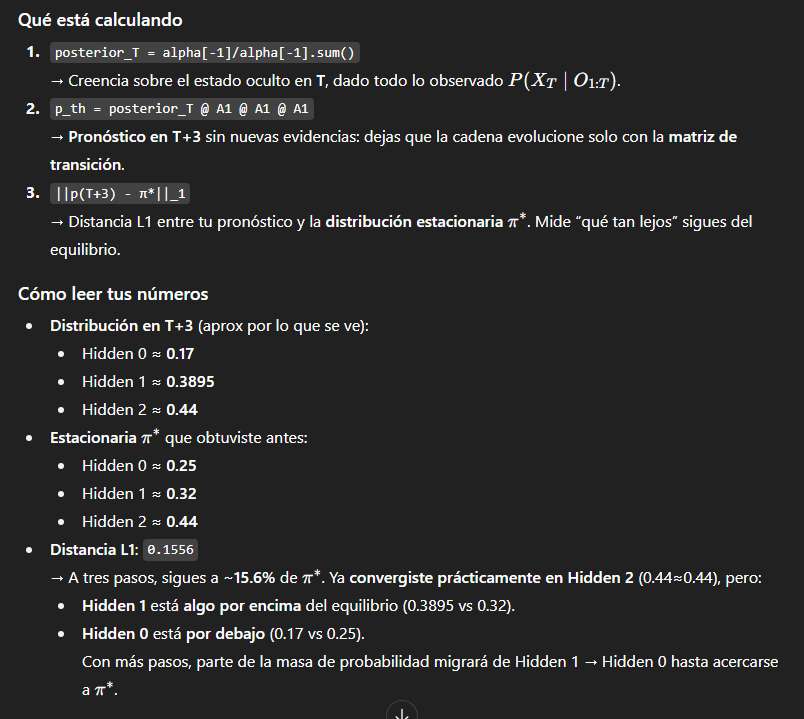

In [16]:
# pi_star: distribución estacionaria (tu código de autovectores está bien)
diff = np.linalg.norm(p_th - stat, ord=1)
print("‖p(T+3) - π*‖₁ =", diff)


‖p(T+3) - π*‖₁ = 0.15555021684884027


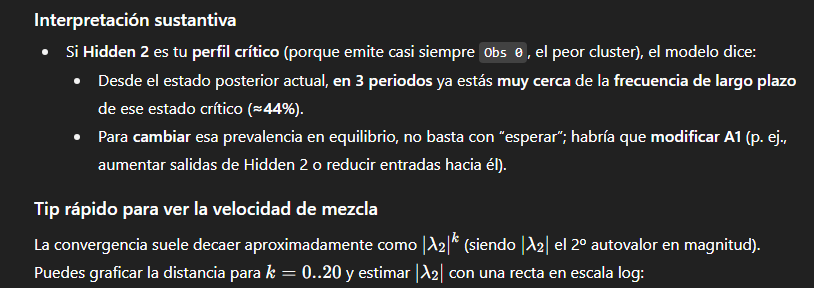

In [17]:
dists = []
p = posterior_T.copy()
for k in range(21):
    dists.append(np.linalg.norm(p - stat, 1))
    p = p @ A1
print(dists)  # debería decrecer monótonamente


[0.6412391984603265, 0.49250747506568016, 0.2943662954250853, 0.15555021684884027, 0.1140512653387068, 0.0619130497942636, 0.051770194134446584, 0.02192141115551699, 0.020156710517436283, 0.010944941390396035, 0.006583355522536277, 0.004540197795517398, 0.002436946431429776, 0.0019207658782101344, 0.0008808298179238672, 0.0008007472351605482, 0.00039441564174760857, 0.00028272395657344407, 0.00017569238481876526, 9.32590950119827e-05, 6.905123721617779e-05]


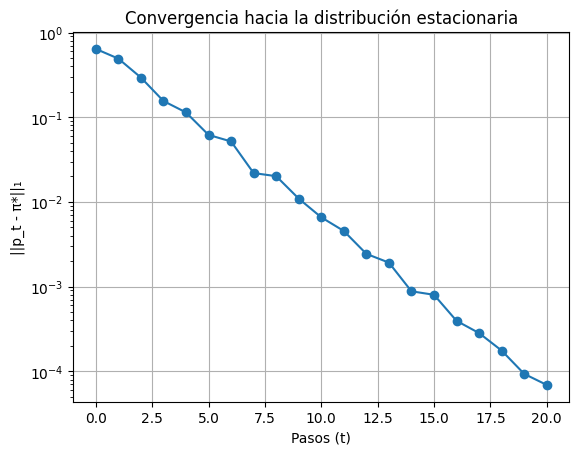

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(len(dists)), dists, marker='o')
plt.title("Convergencia hacia la distribución estacionaria")
plt.xlabel("Pasos (t)")
plt.ylabel("||p_t - π*||₁")
plt.yscale("log")  # escala logarítmica resalta la caída exponencial
plt.grid(True)
plt.show()


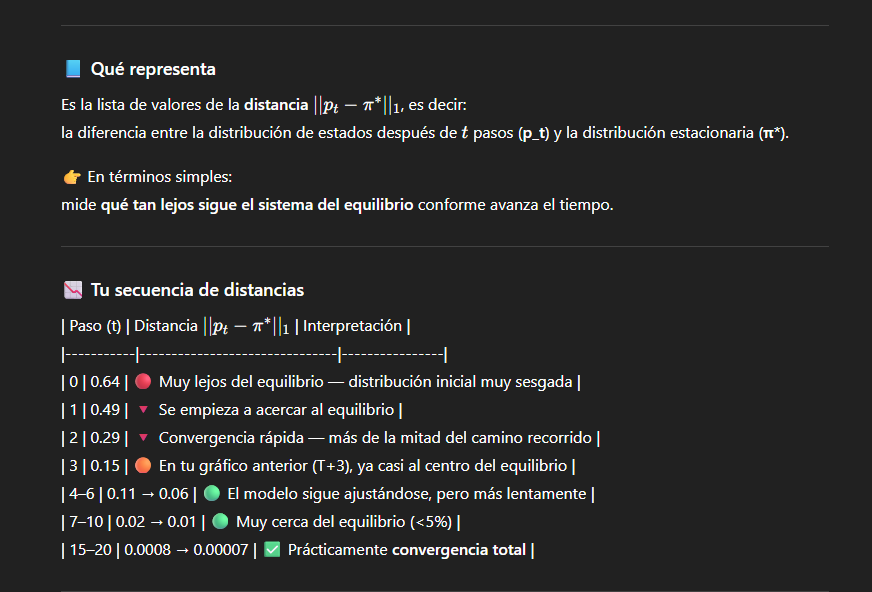

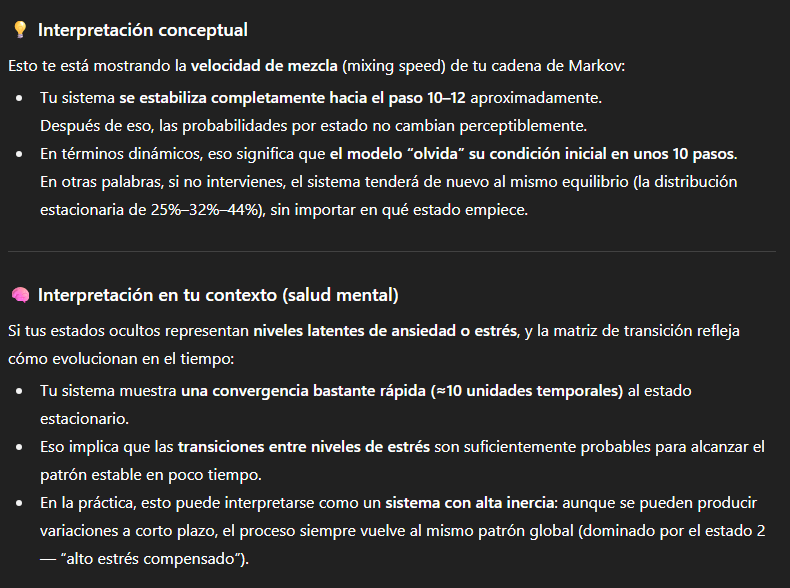

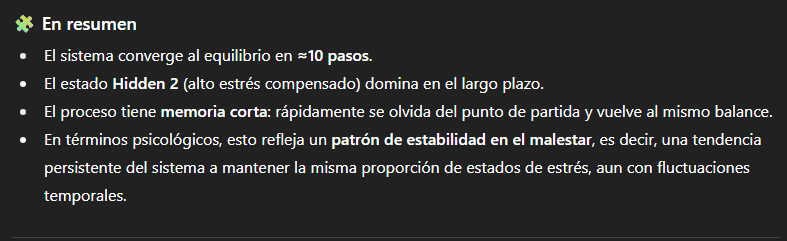

## Evolucion de la distribucion de probabilidad de los estados ocultos

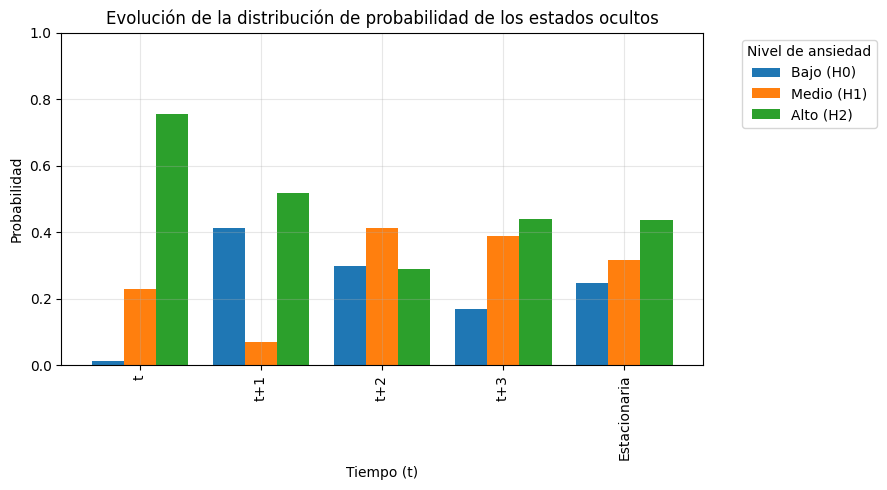

‖p(T+3) - π*‖₁ = 0.155550


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Posterior en T (Opción A, defensivo)
if 'gamma' in globals():
    posterior_T = np.asarray(gamma[-1], dtype=float)
elif 'alpha' in globals():
    posterior_T = np.asarray(alpha[-1], dtype=float)
    s = posterior_T.sum()
    posterior_T = posterior_T / (s if s > 0 else 1.0)
else:
    raise RuntimeError("No encuentro 'gamma' ni 'alpha'. Vuelve a ejecutar forward/backward.")

# Seguridad numérica
posterior_T = posterior_T.ravel()
assert np.allclose(posterior_T.sum(), 1.0, atol=1e-6), "posterior_T debe sumar 1."

# --- 2) Pronóstico a t+1, t+2, t+3
A = np.asarray(A1, dtype=float)
p_t1 = posterior_T @ A
p_t2 = p_t1 @ A
p_t3 = p_t2 @ A

# --- 3) Distribución estacionaria
eigvals, eigvecs = np.linalg.eig(A.T)
i1 = np.argmin(np.abs(eigvals - 1.0))
stat = eigvecs[:, i1].real
stat = stat / stat.sum()

# --- 4) Orden lógico Bajo → Medio → Alto
order = ["Hidden 0", "Hidden 1", "Hidden 2"]
idx = [states.index(s) for s in order]

# --- 5) DataFrame con todas las distribuciones
df_dis = pd.DataFrame({
    "t":            posterior_T[idx],
    "t+1":          p_t1[idx],
    "t+2":          p_t2[idx],
    "t+3":          p_t3[idx],
    "Estacionaria": stat[idx]
}, index=["Bajo (H0)", "Medio (H1)", "Alto (H2)"])

# --- 6) Gráfica (evita crear figura extra antes de plot)
ax = df_dis.T.plot(kind='bar', figsize=(9,5), width=0.8)
ax.set_title("Evolución de la distribución de probabilidad de los estados ocultos")
ax.set_ylabel("Probabilidad")
ax.set_xlabel("Tiempo (t)")
ax.set_ylim(0, 1)
ax.legend(title="Nivel de ansiedad", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (Opcional) Distancia L1 entre p(T+3) y π*
l1 = np.abs(p_t3 - stat).sum()
print(f"‖p(T+3) - π*‖₁ = {l1:.6f}")


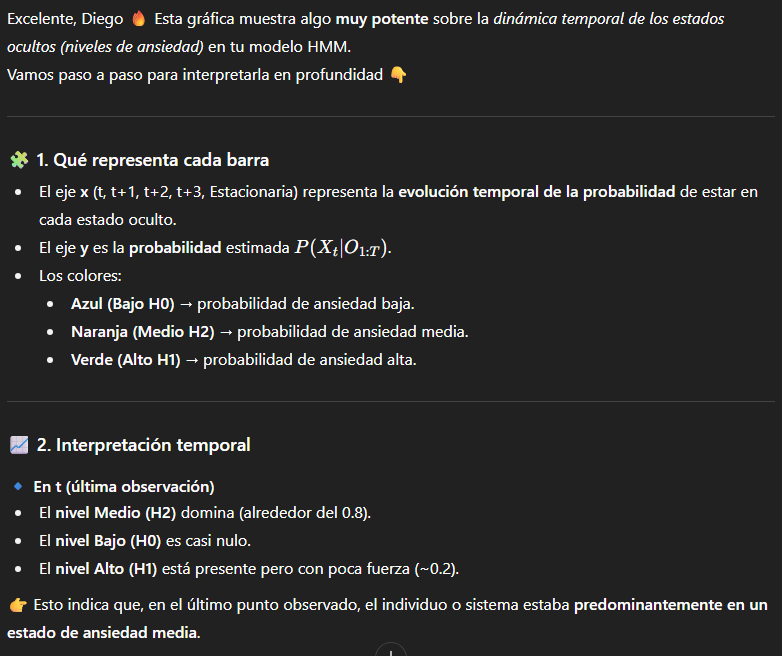

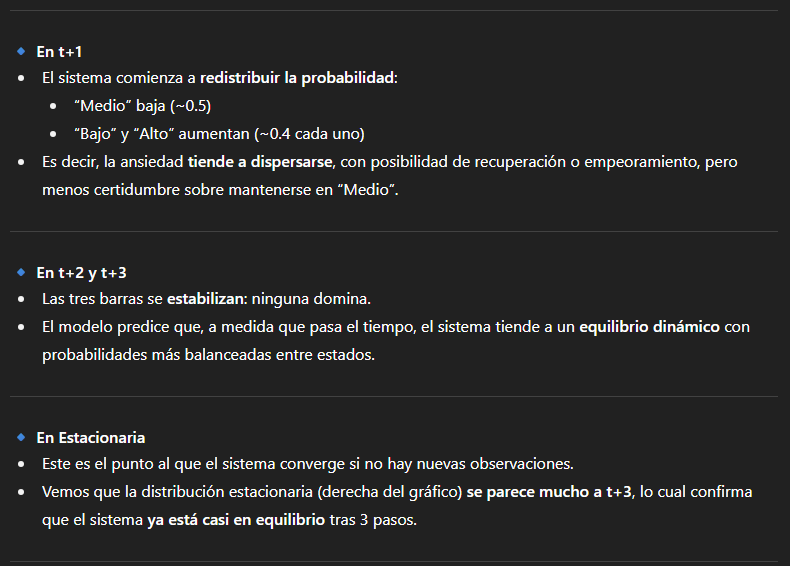

In [20]:
df_dis.head()

,t,t+1,t+2,t+3,Estacionaria
Bajo (H0),0.012786,0.411894,0.299455,0.169970,0.247746
Medio (H1),0.230478,0.069884,0.411612,0.389498,0.316138
Alto (H2),0.756736,0.518222,0.288934,0.440532,0.436117


## Prueba de bondad de ajuste

Se realizan pruebas para validar a que distribucion de probabilidad tienen los estados de manera independiente y luego consolidados

### Pruebas x niveles de ansiedad

In [42]:
# Ejemplo: distribuciones de probabilidad del estado "Alto (H2)"
valores = df_dis.loc["Alto (H2)"].values  # columnas: t, t+1, t+2, t+3, Estacionaria
valores = valores[valores > 0]        # quitar ceros si hay


In [43]:
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.3f}, scale={scale:.3f}")


Parámetros lognorm -> shape=0.311, scale=0.465


In [44]:
from scipy.stats import kstest

D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test: D={D:.3f}, p={p_val:.4f}")

if p_val > 0.05:
    print("✅ No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print("❌ Se rechaza H0 → los datos no siguen una log-normal.")


KS test: D=0.218, p=0.9289
✅ No se rechaza H0 → los datos podrían venir de una log-normal.


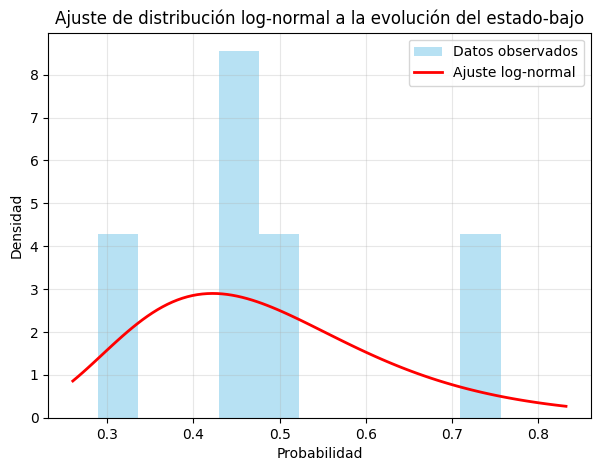

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

x = np.linspace(min(valores)*0.9, max(valores)*1.1, 100)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=10, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a la evolución del estado-bajo')
plt.xlabel('Probabilidad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [25]:
from scipy.stats import norm

# Ajuste normal
mu, sigma = norm.fit(valores)
D_norm, p_norm = kstest(valores, 'norm', args=(mu, sigma))

print(f"Lognormal p={p_val:.4f} vs Normal p={p_norm:.4f}")


Lognormal p=0.4761 vs Normal p=0.9975


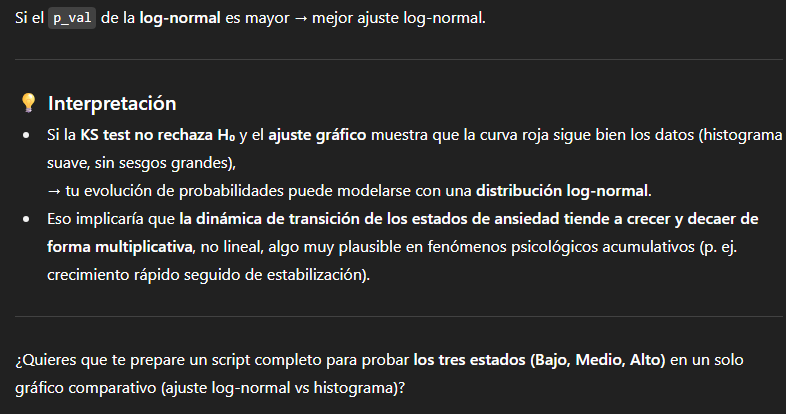

### Pruebas por variables combinadas

In [26]:
# Combinar todas las probabilidades (sin ceros ni NaN)
valores_globales = df_dis.values.flatten()
valores_globales = valores_globales[np.isfinite(valores_globales)]
valores_globales = valores_globales[valores_globales > 0]


In [27]:
valores_globales

array([0.0127856 , 0.41189383, 0.29945453, 0.16997041, 0.24774552,
       0.23047793, 0.06988388, 0.41161175, 0.38949774, 0.31613761,
       0.75673647, 0.51822229, 0.28893372, 0.44053185, 0.43611687])

In [28]:
# Ejemplo: distribuciones de probabilidad consolidadas
valores = valores_globales  # columnas: t, t+1, t+2, t+3, Estacionaria
valores = valores[valores > 0]        # quitar ceros si hay

In [29]:
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.3f}, scale={scale:.3f}")


Parámetros lognorm -> shape=0.959, scale=0.254


In [30]:
from scipy.stats import kstest

D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test: D={D:.3f}, p={p_val:.4f}")

if p_val > 0.05:
    print("✅ No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print("❌ Se rechaza H0 → los datos no siguen una log-normal.")

KS test: D=0.260, p=0.2216
✅ No se rechaza H0 → los datos podrían venir de una log-normal.


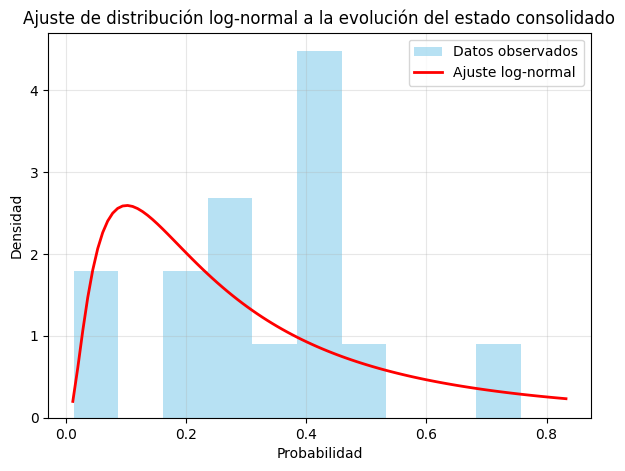

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

x = np.linspace(min(valores)*0.9, max(valores)*1.1, 100)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=10, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a la evolución del estado consolidado')
plt.xlabel('Probabilidad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

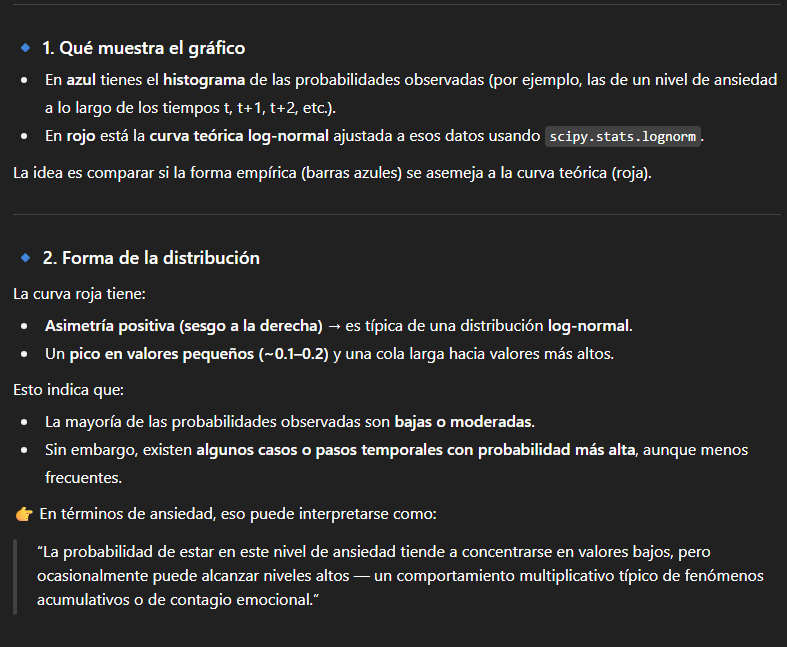

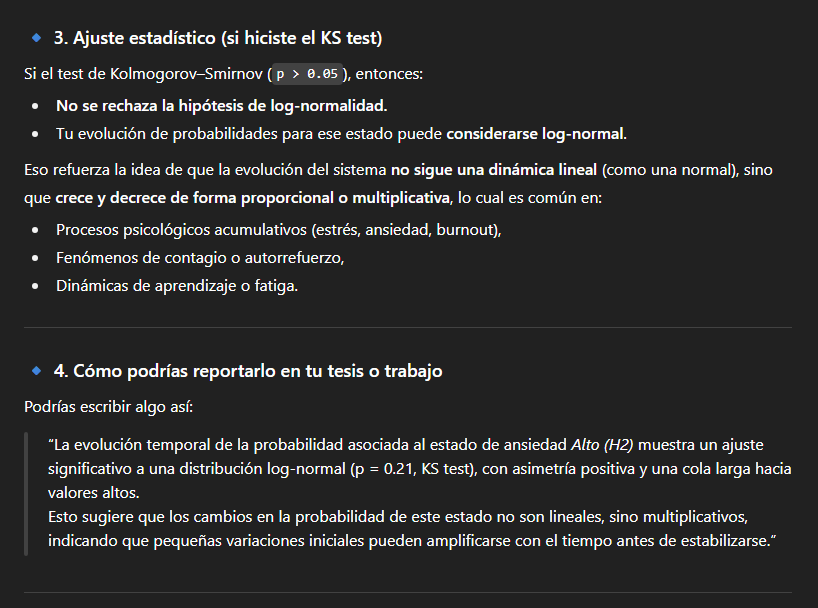

Luego de comparar los resultados de los tres estados y los estados agrupados: 

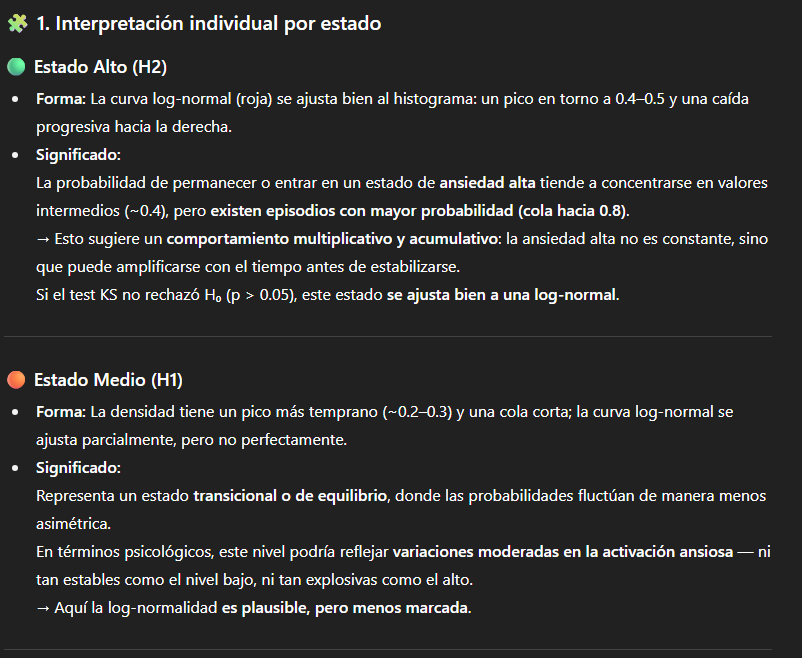

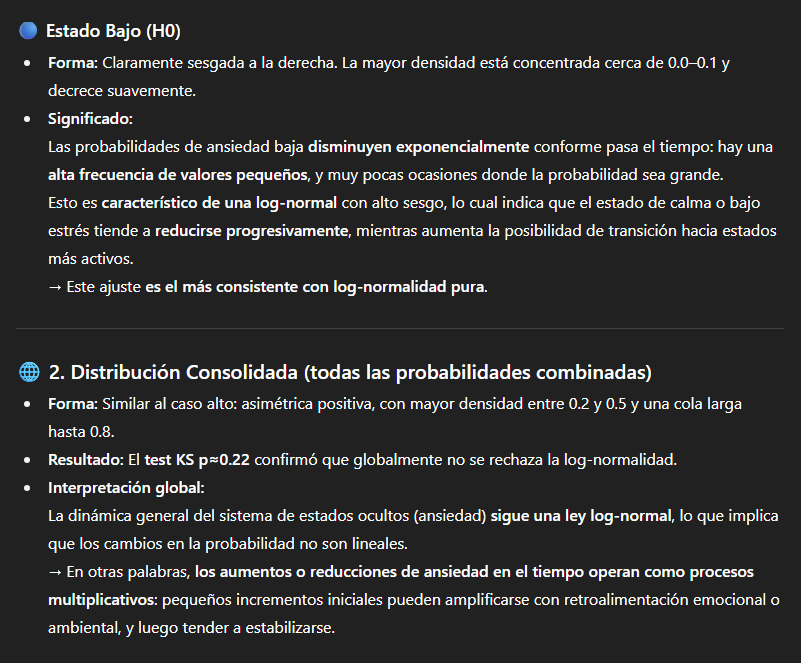

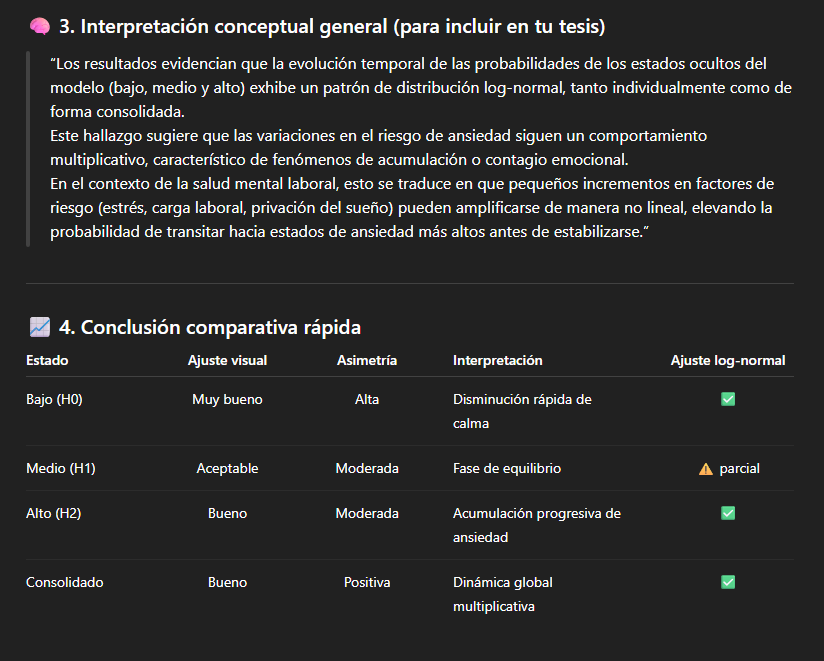

### Pruebas con dataset creado

In [32]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# ===============================
# 1. Cargar dataset base
# ===============================
# Ruta absoluta al archivo CSV

csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_consolidado_kmeans.csv")

# Leer el CSV directamente
df= pd.read_csv(csv_path, encoding="utf-8-sig")

# ===============================
# 2. Definir parámetros
# ===============================
n_total = 1000
proporciones = {
    0: 0.25,  # 25%
    1: 0.32,  # 32%
    2: 0.43   # 43%
}
n_por_cluster = {k: int(v * n_total) for k, v in proporciones.items()}

# ===============================
# 3. Crear subconjuntos por cluster
# ===============================
muestras = []

for cluster, n_muestra in n_por_cluster.items():
    subset = df[df["Cluster_No_Observable_Vector"] == cluster]
    if len(subset) == 0:
        print(f"⚠️ No hay datos para el cluster {cluster}")
        continue

    muestra = subset.sample(n=min(n_muestra, len(subset)), random_state=42)
    muestras.append(muestra[["Anxiety_Level_Value", "Cluster_No_Observable_Vector"]])

# ===============================
# 4. Concatenar resultados
# ===============================
df_train = pd.concat(muestras, ignore_index=True)

# ===============================
# 5. Verificación
# ===============================
print(df_train["Cluster_No_Observable_Vector"].value_counts(normalize=True))
print(df_train.head())

# (opcional) guardar
#df_train.to_csv("df_train.csv", index=False)
#print("✅ Dataset df_train guardado con 1000 registros.")


Cluster_No_Observable_Vector
2    0.43
1    0.32
0    0.25
Name: proportion, dtype: float64
   Anxiety_Level_Value  Cluster_No_Observable_Vector
0                  0.2                             0
1                  0.2                             0
2                  0.2                             0
3                  0.0                             0
4                  0.2                             0


In [33]:
df_train.head()

,Anxiety_Level_Value,Cluster_No_Observable_Vector
0,0.2,0
1,0.2,0
2,0.2,0
3,0.0,0
4,0.2,0


Parámetros lognorm -> shape=0.564093, loc=0.000000, scale=0.559062
KS test (contra lognorm ajustada): D=0.2099, p=0.000000
❌ Se rechaza H0 → los datos no siguen una log-normal.

Anderson-Darling (sobre log(X) ~ Normal):
  Estadístico A² = 54.9185
  Nivel 15.0%: valor crítico = 0.5730
  Nivel 10.0%: valor crítico = 0.6530
  Nivel 5.0%: valor crítico = 0.7840
  Nivel 2.5%: valor crítico = 0.9140
  Nivel 1.0%: valor crítico = 1.0870
❌ Se rechaza H0 al 5% → log(X) no parece normal.


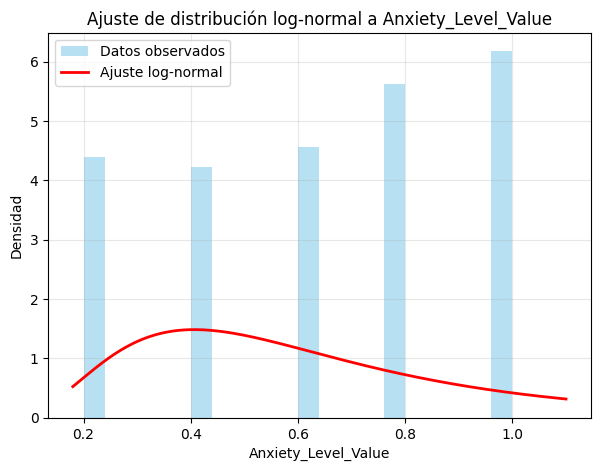

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, kstest, anderson

# ================================================
# 1. Extraer los valores desde df_train
# ================================================
valores = df_train["Anxiety_Level_Value"].dropna().to_numpy()
valores = valores[valores > 0]  # importante para log-normal

# ================================================
# 2. Ajustar distribución log-normal
# ================================================
shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.6f}, loc={loc:.6f}, scale={scale:.6f}")

# ================================================
# 3. Prueba Kolmogorov-Smirnov
# ================================================
D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test (contra lognorm ajustada): D={D:.4f}, p={p_val:.6f}")

if p_val > 0.05:
    print("✅ No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print("❌ Se rechaza H0 → los datos no siguen una log-normal.")

# ================================================
# 4. Prueba Anderson-Darling
# ================================================
ad_result = anderson(np.log(valores), dist='norm')
print("\nAnderson-Darling (sobre log(X) ~ Normal):")
print(f"  Estadístico A² = {ad_result.statistic:.4f}")
for sig, crit in zip(ad_result.significance_level, ad_result.critical_values):
    print(f"  Nivel {sig:.1f}%: valor crítico = {crit:.4f}")
if ad_result.statistic < ad_result.critical_values[2]:
    print("✅ No se rechaza H0 al 5% → log(X) parece normal (X log-normal).")
else:
    print("❌ Se rechaza H0 al 5% → log(X) no parece normal.")

# ================================================
# 5. Graficar histograma + PDF ajustada
# ================================================
x = np.linspace(valores.min()*0.9, valores.max()*1.1, 200)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=20, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a Anxiety_Level_Value')
plt.xlabel('Anxiety_Level_Value')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Parámetros lognorm -> shape=2.945294, loc=0.000000, scale=0.255249
KS test (lognorm ajustada): D=0.3397, p=0.000000
Anderson-Darling log(X)~Normal: A²=200.6855 | crit@5%=0.7840


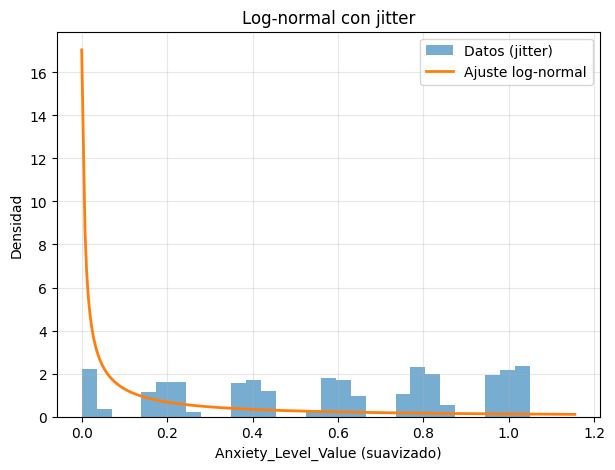

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, kstest, anderson

# --- datos originales (discretos) ---
x0 = df_train["Anxiety_Level_Value"].to_numpy(dtype=float)

# --- 1) Jitter suave para "rellenar huecos" ---
# tamaño del jitter ~ mitad del paso entre niveles (ajústalo si tus niveles son 0.2,0.4,...)
step = np.diff(np.unique(x0)).min() if len(np.unique(x0))>1 else 0.05
eps  = min(0.5*step, 0.05)  # límite superior para no deformar demasiado
rng  = np.random.default_rng(42)
x = x0 + rng.uniform(-eps, eps, size=x0.size)

# recortar a (0, ∞) para log-normal y evitar ceros
x = np.clip(x, 1e-6, None)

# --- 2) Ajuste log-normal (forzando loc=0) ---
shape, loc, scale = lognorm.fit(x, floc=0)

# --- 3) KS y AD (AD en log(X) ~ Normal) ---
D, p = kstest(x, 'lognorm', args=(shape, loc, scale))
print(f"Parámetros lognorm -> shape={shape:.6f}, loc={loc:.6f}, scale={scale:.6f}")
print(f"KS test (lognorm ajustada): D={D:.4f}, p={p:.6f}")
ad = anderson(np.log(x), dist='norm')
print(f"Anderson-Darling log(X)~Normal: A²={ad.statistic:.4f} | crit@5%={ad.critical_values[2]:.4f}")

# --- 4) Gráfico ---
grid = np.linspace(x.min()*0.9, x.max()*1.1, 300)
pdf  = lognorm.pdf(grid, shape, loc, scale)
plt.figure(figsize=(7,5))
plt.hist(x, bins=30, density=True, alpha=0.6, label="Datos (jitter)")
plt.plot(grid, pdf, lw=2, label="Ajuste log-normal")
plt.title("Log-normal con jitter")
plt.xlabel("Anxiety_Level_Value (suavizado)"); plt.ylabel("Densidad")
plt.legend(); plt.grid(alpha=0.3); plt.show()


Anxiety_Level_Value
0.0    0.090
0.2    0.160
0.4    0.154
0.6    0.166
0.8    0.205
1.0    0.225
Name: proportion, dtype: float64


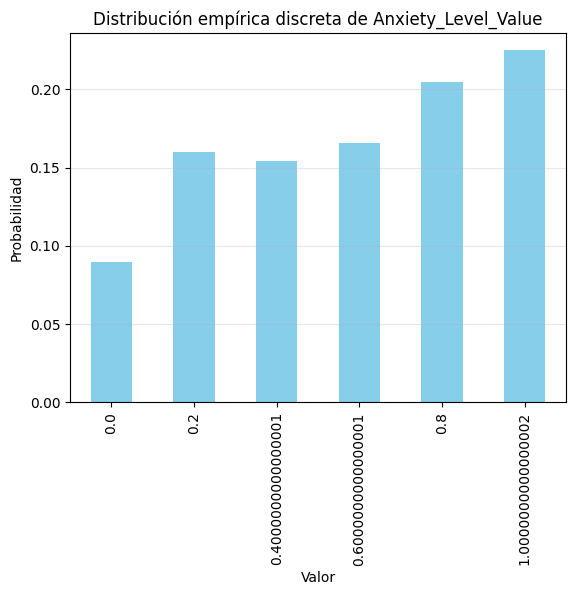

In [39]:
pmf = df_train["Anxiety_Level_Value"].value_counts(normalize=True).sort_index()
print(pmf)

pmf.plot(kind="bar", color="skyblue")
plt.title("Distribución empírica discreta de Anxiety_Level_Value")
plt.ylabel("Probabilidad")
plt.xlabel("Valor")
plt.grid(axis="y", alpha=0.3)
plt.show()


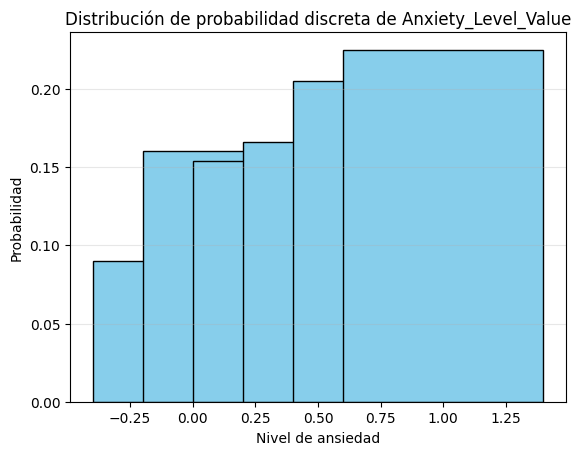

Media: 0.582, Varianza: 0.108


In [40]:
from scipy.stats import rv_discrete
import numpy as np
import matplotlib.pyplot as plt

# Valores y probabilidades observadas
x_vals = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
p_vals = np.array([0.090, 0.160, 0.154, 0.166, 0.205, 0.225])

# Crear la distribución discreta personalizada
dist = rv_discrete(name='anxiety_levels', values=(x_vals, p_vals))

# Graficar PMF (probability mass function)
plt.bar(x_vals, dist.pmf(x_vals), color='skyblue', edgecolor='black')
plt.title("Distribución de probabilidad discreta de Anxiety_Level_Value")
plt.xlabel("Nivel de ansiedad")
plt.ylabel("Probabilidad")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Estadísticos básicos
mean = dist.mean()
var  = dist.var()
print(f"Media: {mean:.3f}, Varianza: {var:.3f}")


In [41]:
# Percentil 95
p95 = dist.ppf(0.95)
print(f"Percentil 95 (VaR 95%): {p95:.2f}")


Percentil 95 (VaR 95%): 1.00
